# Causal Analysis of Synthetic Dataset

In [235]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import random
import seaborn as sns
from pymatch.Matcher import Matcher
from pymatch.functions import ks_boot
from joblib import Parallel, delayed

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT_COL = 'ContinentOfBirth'
#TREATMENT_COL = 'CitizenshipContinent'

treatment_subdimensions = ['CitizenshipCountry'] if TREATMENT_COL == 'CitizenshipContinent' else ['CountryOfBirth']

OUTCOME_NAME = 'Last Name Correct'

TREATMENT = 'T'
OUTCOME = 'O'

In [236]:
dataset = pd.read_csv('data/synthetic-dataset-scenario-B.csv')
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'Last Name Correct'],
      dtype='object')

In [237]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT] = dataset[TREATMENT_COL] == 'Asia'
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)
dataset.head()

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL, 'Last Name'] + treatment_subdimensions, axis=1).columns.values
CONT_COVARIATES = ['NumChildren']
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

## Analysis with Matching through PyMatch

In [4]:
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'O', 'T'],
      dtype='object')

In [4]:
m = Matcher(dataset[dataset[TREATMENT]], dataset[~dataset[TREATMENT]], yvar=TREATMENT, exclude=['Last Name', TREATMENT_COL, treatment_subdimensions, OUTCOME])

Formula:
T ~ Source+CitizenshipCountry+CitizenshipContinent+NumChildren+MaritalStatus
n majority: 6648
n minority: 3352


Fitting Models on Balanced Samples: 1\50

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pymatch\Matcher.py:103: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  uf.drop_static_cols(df[df[self.yvar] == 0], yvar=self.yvar)])


Fitting Models on Balanced Samples: 50\50
Average Accuracy: 92.69%


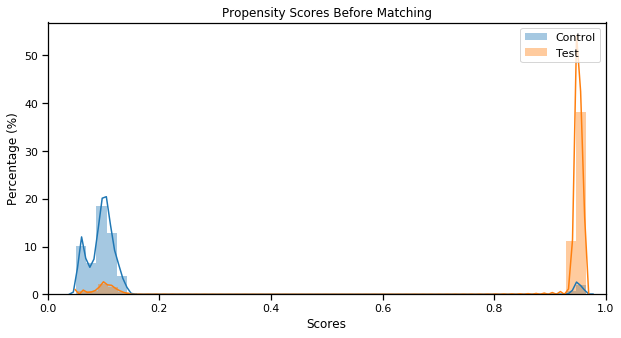

In [5]:
m.fit_scores(balance=True, nmodels=50)
m.predict_scores()
#m.plot_scores()

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pymatch\Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pymatch\Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index


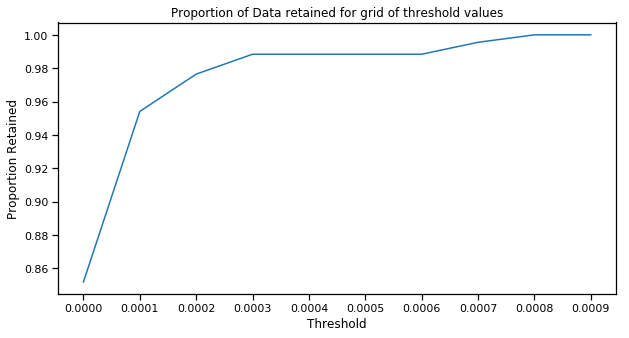

In [50]:
m.tune_threshold(method='random')

In [61]:
m.match(method="min", nmatches=1, threshold=0.0002)
m.record_frequency()

,freq,n_records
0,1,3514
1,2,50
2,3,22
3,4,2
4,6,1
5,7,1
6,11,2
7,12,3
8,13,3
9,14,7


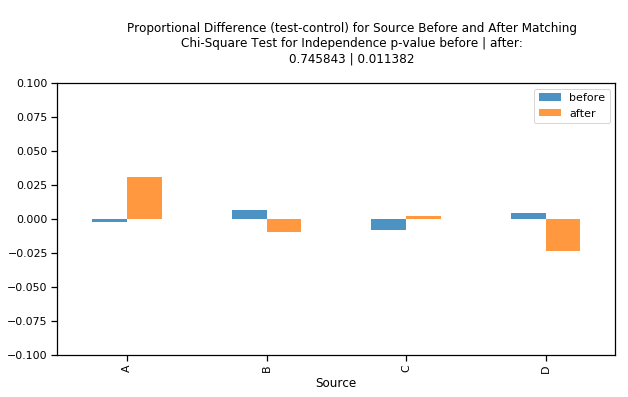

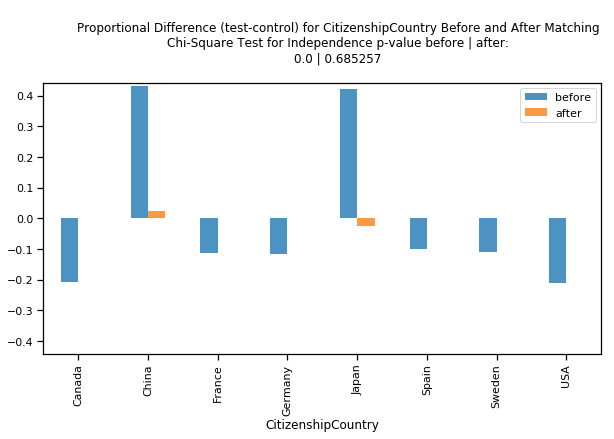

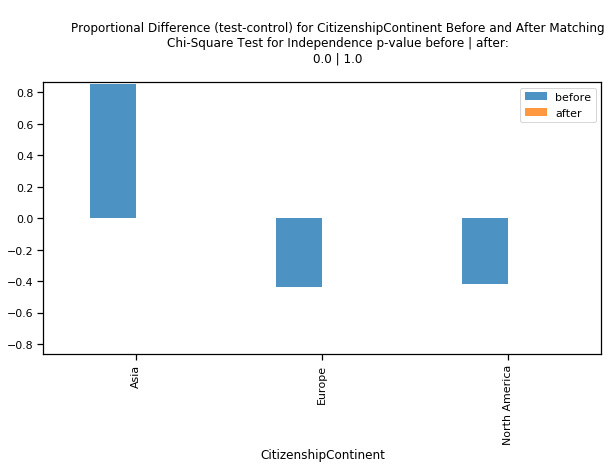

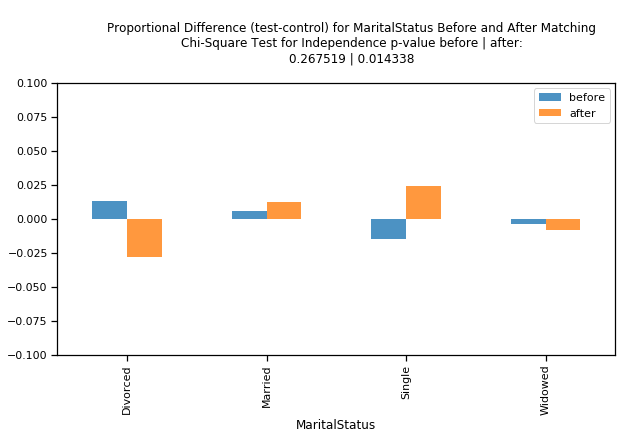

In [62]:
m.assign_weight_vector()
categorical_results = m.compare_categorical(return_table=True)

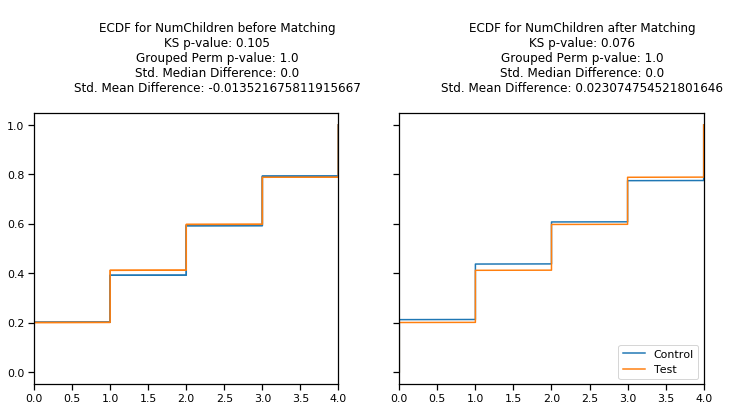

In [63]:
cc = m.compare_continuous(return_table=True)

In [64]:
# ATE through propensity score matching
matched_data = m.matched_data.copy()
treated = matched_data[matched_data[TREATMENT] == 1].set_index('match_id')
control = matched_data[matched_data[TREATMENT] != 1].set_index('match_id')

matched = treated.join(control, lsuffix='_treated', rsuffix='_control')
matched['treatment_effect'] = matched[OUTCOME+'_treated'].astype(int) - matched[OUTCOME+'_control'].astype(int)

ate = matched['treatment_effect'].mean()
ate